In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# Set device id to 1 


# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


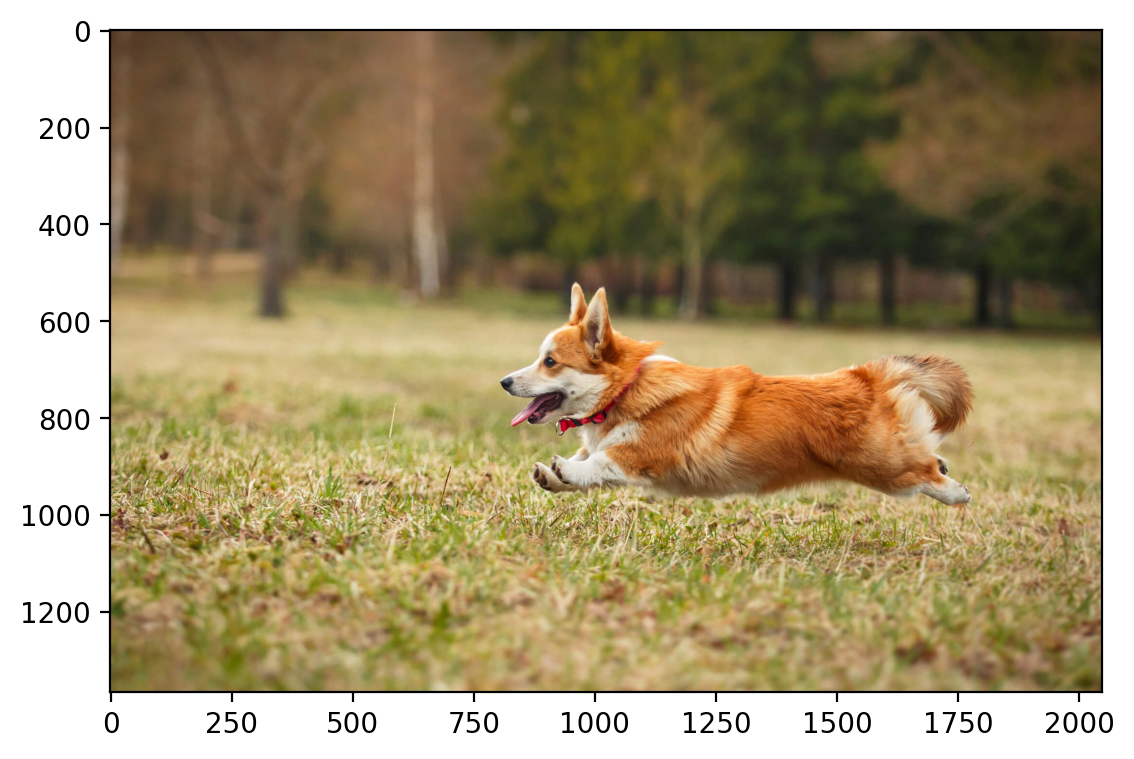

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
# We normalize the image to be between 0 and 1
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)

In [7]:
# Cropping the image at fixed location around the face of the dog
crop = torchvision.transforms.functional.crop(img_scaled.cpu(),670, 830, 100, 100)
crop.shape

torch.Size([3, 100, 100])

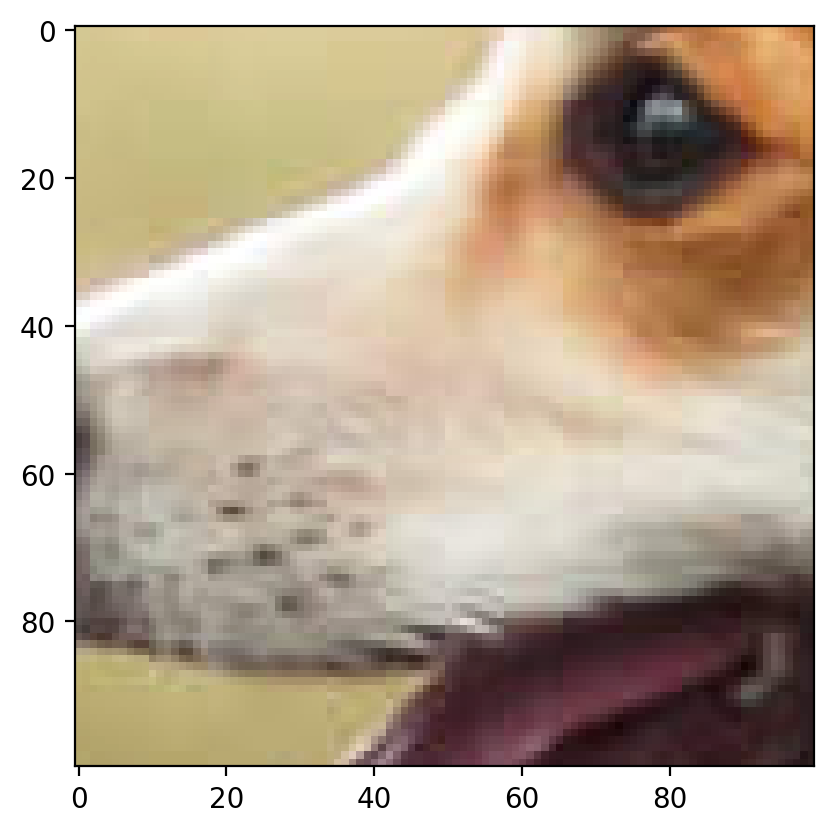

In [8]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [9]:
crop = crop.to(device)

In [10]:
def create_coordinate_map(img, sampling_percentage = 0):
    
    if sampling_percentage != 0:
        num_channels, height, width = img.shape
        total_points = height * width
        num_sampled_points = int(total_points * sampling_percentage)
        
        sampled_indices = torch.randperm(total_points)[:num_sampled_points]
        
        w_coords = sampled_indices % width
        h_coords = sampled_indices // width
        
        X = torch.stack([h_coords, w_coords], dim=1).float()
        X = X.to(img.device)
        Y = rearrange(img, 'c h w -> (h w) c').float()
        Y_sampled = Y[sampled_indices, :]
        
        scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())
        X_scaled = scaler_X.transform(X.cpu())
        X_scaled = torch.tensor(X_scaled).to(device)
        X_scaled = X_scaled.float()

        return X_scaled, Y_sampled, h_coords, w_coords
    
    else:
        num_channels, height, width = img.shape
    
        coords = np.array([[i, j] for i in range(width) for j in range(width)])
        X = torch.tensor(coords)

        # Move X to GPU if available
        X = X.to(img.device)
        
        scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())
        X_scaled = scaler_X.transform(X.cpu())
        X_scaled = torch.tensor(X_scaled).to(device)
        X_scaled = X_scaled.float()
        
        return X_scaled

In [11]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [12]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [50]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape    
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.show()

In [51]:
# create RFF features
from sklearn.kernel_approximation import RBFSampler
def create_rff_features(X, num_features, sigma, random_seed=100):
    import numpy as np
    np.random.seed(random_seed)
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=random_seed)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [63]:
def callback(crop,percent): #Percentage of missing data
    features = 20000 ; sigma = 0.07
    dog_X, dog_Y, h_coords, w_coords = create_coordinate_map(crop, percent)
    X_rff = create_rff_features(dog_X, features, sigma)
    
    net = LinearModel(X_rff.shape[1], 3)
    net.to(device)
    train(net, 0.005, X_rff.to(device), dog_Y.to(device), 500)
    
    X = create_coordinate_map(crop, 0)
    
    X_rff = create_rff_features(X, features, sigma)

    img_erased = torch.zeros_like(crop)
    img_erased[:, h_coords, w_coords] = crop[:, h_coords, w_coords]

    plot_reconstructed_and_original_image(img_erased, net, X_rff, title="Reconstructed Image with RFF Features with {:.0f}% missing data".format(percent * 100))

Epoch 0 loss: 0.442962
Epoch 100 loss: 0.001870
Epoch 200 loss: 0.000678
Epoch 300 loss: 0.000451
Epoch 400 loss: 0.000363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


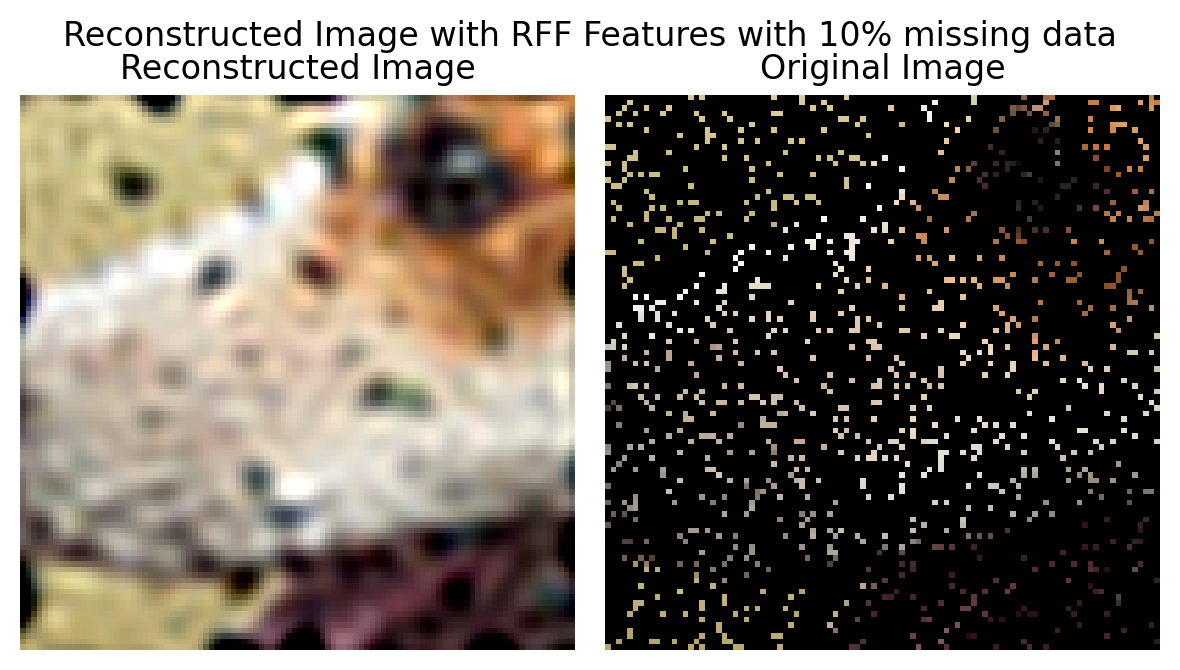

Epoch 0 loss: 0.430420
Epoch 100 loss: 0.001716
Epoch 200 loss: 0.000831
Epoch 300 loss: 0.000677
Epoch 400 loss: 0.000618


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


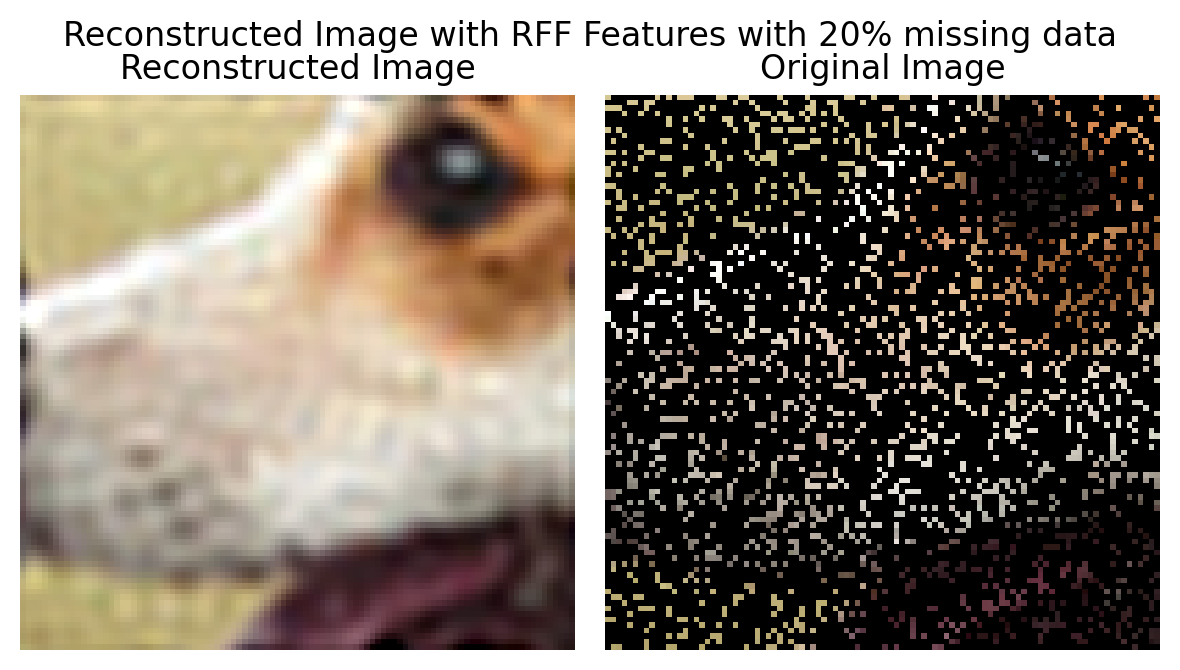

Epoch 0 loss: 0.432754
Epoch 100 loss: 0.001474
Epoch 200 loss: 0.000897
Epoch 300 loss: 0.000800
Epoch 400 loss: 0.000759


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


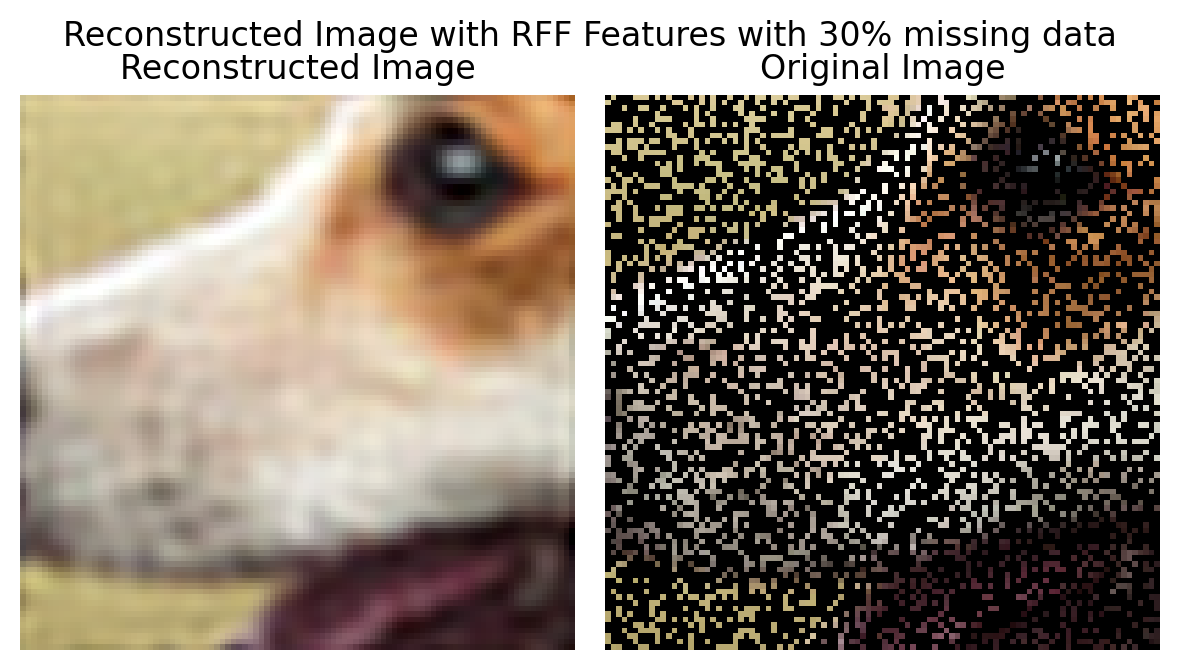

Epoch 0 loss: 0.428264
Epoch 100 loss: 0.001426
Epoch 200 loss: 0.000873
Epoch 300 loss: 0.000774
Epoch 400 loss: 0.000735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


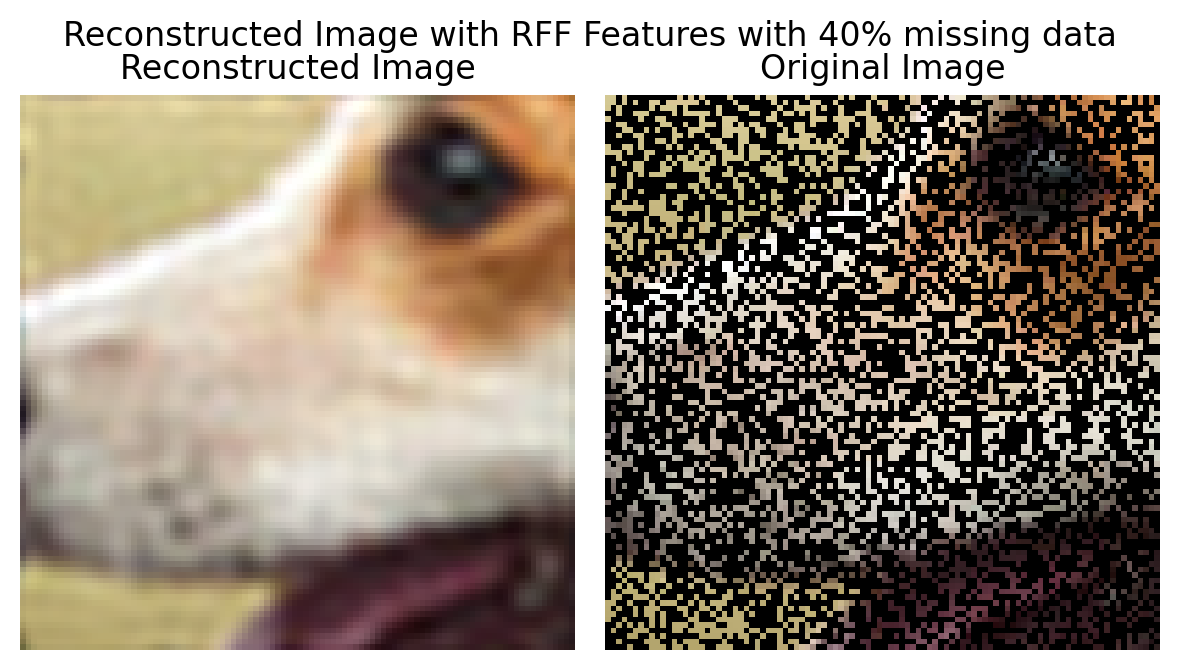

Epoch 0 loss: 0.431803
Epoch 100 loss: 0.001482
Epoch 200 loss: 0.001022
Epoch 300 loss: 0.000935
Epoch 400 loss: 0.000895


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


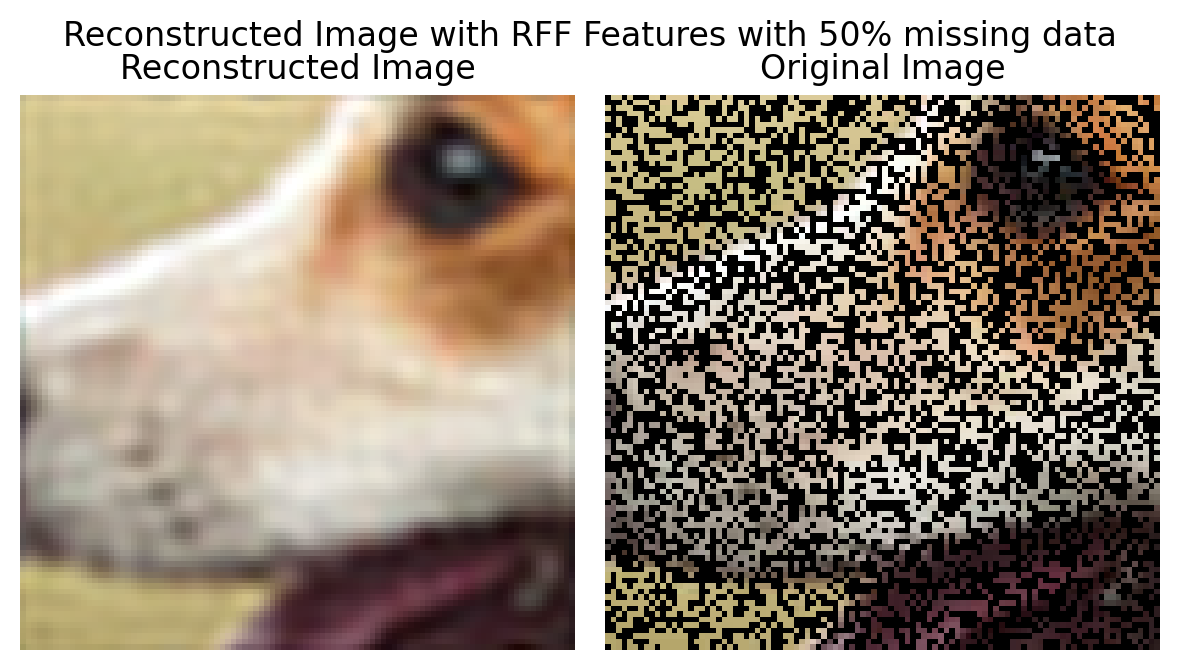

Epoch 0 loss: 0.437365
Epoch 100 loss: 0.001402
Epoch 200 loss: 0.000999
Epoch 300 loss: 0.000919
Epoch 400 loss: 0.000881


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


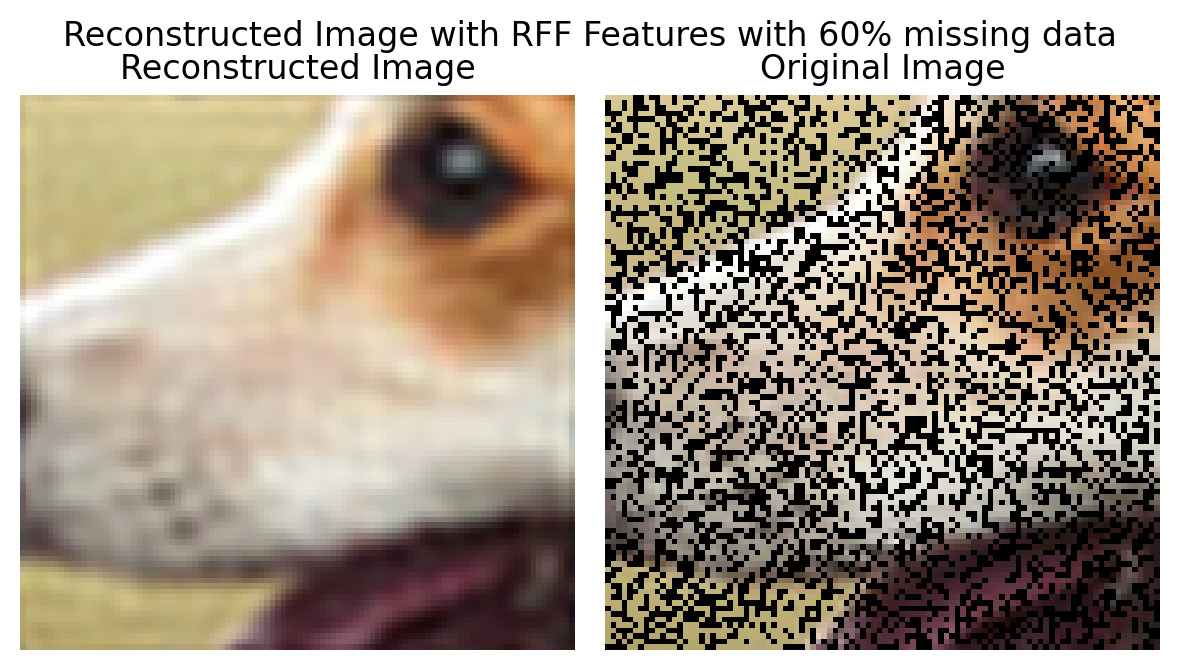

Epoch 0 loss: 0.432255
Epoch 100 loss: 0.001399
Epoch 200 loss: 0.001004
Epoch 300 loss: 0.000929
Epoch 400 loss: 0.000892


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


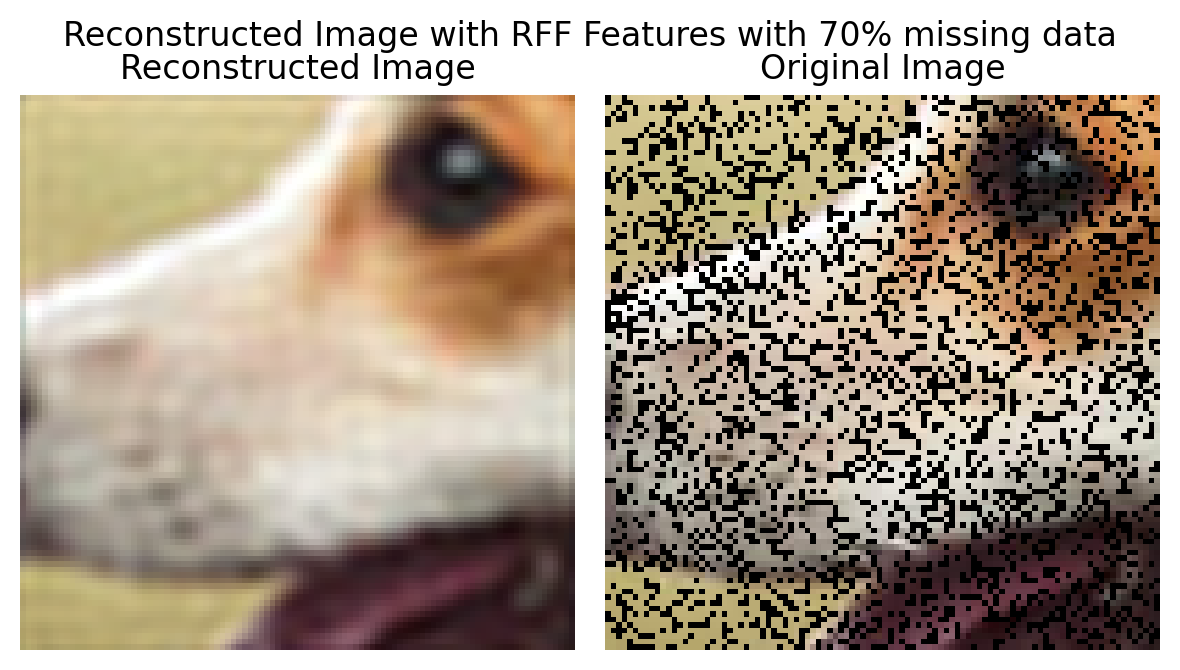

Epoch 0 loss: 0.433081
Epoch 100 loss: 0.001370
Epoch 200 loss: 0.000990
Epoch 300 loss: 0.000917
Epoch 400 loss: 0.000881


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


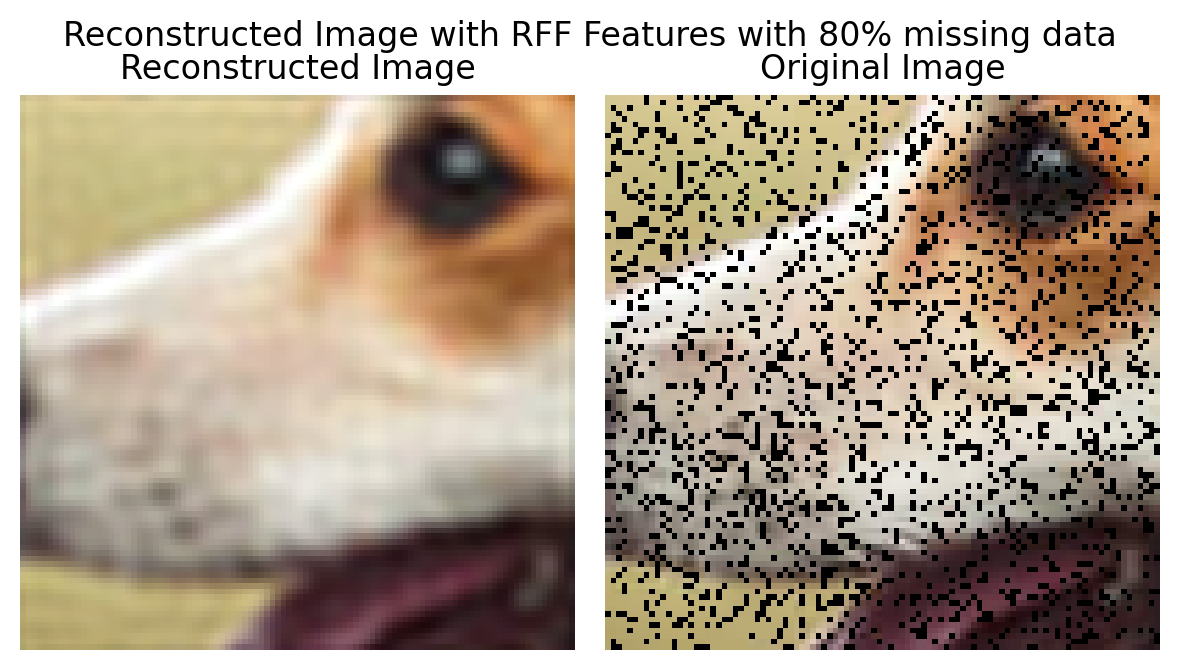

Epoch 0 loss: 0.436759
Epoch 100 loss: 0.001381
Epoch 200 loss: 0.001015
Epoch 300 loss: 0.000939
Epoch 400 loss: 0.000902


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


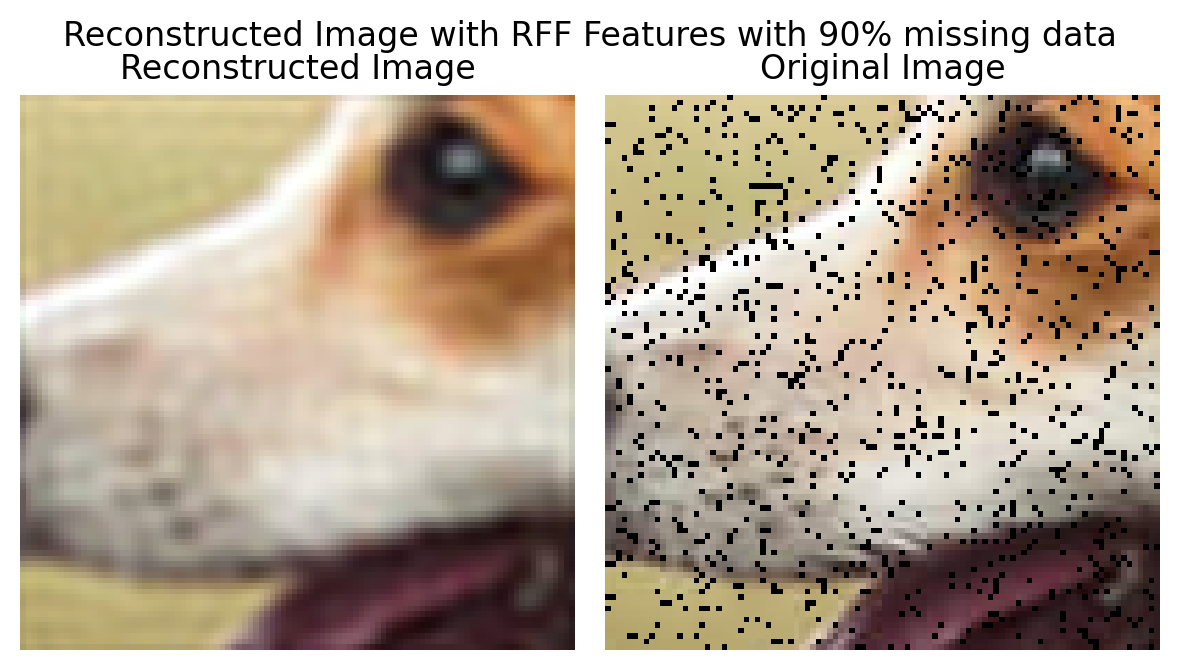

In [64]:
for i in np.linspace(0.1,0.9,9): 
    callback(crop,i)